In [1]:
import os, copy, gc, tqdm, yaml
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from functools import partial
from collections import defaultdict
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, RobustScaler

2024-02-22 10:39:25.841459: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-22 10:39:25.881152: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 10:39:25.881188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 10:39:25.882438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 10:39:25.890634: I tensorflow/core/platform/cpu_feature_guar

### Load a configuation yaml 

In [2]:
config = "../config/surface_layer/mlp.yml"

In [3]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

### Load example training data (the full data set is available on Zenodo ... ) 

In [4]:
fn = "../data/sample_cabauw_surface_layer.csv"

In [5]:
input_cols = conf["data"]["input_cols"]
output_cols = ['friction_velocity:surface:m_s-1']

In [6]:
data_seed = 0
flat_seed = 1000

n_splits = 1
n_models = 1

data = pd.read_csv(fn)
data["day"] = data["Time"].apply(lambda x: str(x).split(" ")[0])

# Need the same test_data for all trained models (data and model ensembles)
flat_seed = 1000
gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
splits = list(gsp.split(data, groups = data["day"]))
train_index, test_index = splits[0]
train_data, test_data = data.iloc[train_index].copy(), data.iloc[test_index].copy() 

# Make N train-valid splits using day as grouping variable
gsp = GroupShuffleSplit(n_splits=n_splits,  random_state = flat_seed, train_size=0.885)
splits = list(gsp.split(train_data, groups = train_data["day"]))
train_index, valid_index = splits[data_seed]
train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy()  

In [7]:
x_scaler, y_scaler = RobustScaler(), MinMaxScaler((0, 1))
x_train = x_scaler.fit_transform(train_data[input_cols])
x_valid = x_scaler.transform(valid_data[input_cols])
x_test = x_scaler.transform(test_data[input_cols])

y_train = y_scaler.fit_transform(train_data[output_cols])
y_valid = y_scaler.transform(valid_data[output_cols])
y_test = y_scaler.transform(test_data[output_cols])

### 1. Deterministic multi-layer perceptron (MLP) to predict some quantity

In [8]:
from mlguess.keras.models import BaseRegressor as RegressorDNN
from mlguess.keras.callbacks import get_callbacks

/glade/work/ggantos/conda-envs/guess/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [9]:
conf["model"]["epochs"] = 1
conf["model"]["verbose"] = 1

In [10]:
model = RegressorDNN(**conf["model"])
model.build_neural_network(x_train.shape[-1], y_train.shape[-1])

2024-02-22 10:39:29.086048: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [11]:
model.fit(
    x_train,
    y_train,
    validation_data=(x_valid, y_valid),
    callbacks=get_callbacks(conf, path_extend=f"")
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 dense_00 (Dense)            (None, 500)               2500      
                                                                 
 dropout_h_00 (Dropout)      (None, 500)               0         
                                                                 
 dense_last (Dense)          (None, 1)                 501       
                                                                 
Total params: 3001 (11.72 KB)
Trainable params: 3001 (11.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
20/20 [==============================] - 1s 23ms/step - loss: 0.0471 - mae: 0.1323 - val_loss: 0.0026 - val_mae: 0.0370 - lr: 4.7274e-04


/glade/work/ggantos/conda-envs/guess/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### Predict with the model

In [12]:
y_pred = model.predict(x_test, y_scaler)

3/3 [==============================] - 0s 3ms/step


In [13]:
mae = np.mean(np.abs(y_pred[:, 0]-test_data[output_cols[0]]))

In [14]:
mae

0.051981883848273056

##### Create a Monte Carlo ensemble

In [15]:
monte_carlo_steps = 10

In [16]:
results = model.predict_monte_carlo(x_test, monte_carlo_steps, y_scaler)

In [17]:
y_scaler.data_range_

array([1.42945997])

In [18]:
mu_ensemble = np.mean(results, axis = 0)
var_ensemble = np.var(results, axis = 0)

In [19]:
mu_ensemble.shape

(7188, 1)

In [20]:
var_ensemble.shape

(7188, 1)

### 2. Predict mu and sigma with a "Gaussian MLP"

In [21]:
from mlguess.keras.models import GaussianRegressorDNN

In [22]:
config = "../config/surface_layer/gaussian.yml"
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)
    
conf["model"]["epochs"] = 1
conf["model"]["verbose"] = 1

In [23]:
gauss_model = GaussianRegressorDNN(**conf["model"])
gauss_model.build_neural_network(x_train.shape[-1], y_train.shape[-1])

In [24]:
gauss_model.fit(
    x_train,
    y_train,
    validation_data=(x_valid, y_valid),
    callbacks=get_callbacks(conf, path_extend=f"")
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 dense_00 (Dense)            (None, 342)               1710      
                                                                 
 dropout_h_00 (Dropout)      (None, 342)               0         
                                                                 
 dense_01 (Dense)            (None, 342)               117306    
                                                                 
 dropout_h_01 (Dropout)      (None, 342)               0         
                                                                 
 DenseNormal (DenseNormal)   (None, 2)                 688       
                                                                 
Total params: 119704 (467.59 KB)
Trainable params: 119702 (

/glade/work/ggantos/conda-envs/guess/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
mu, var = gauss_model.predict_uncertainty(x_test, y_scaler)

3/3 [==============================] - 0s 6ms/step


In [26]:
# compute variance and std from learned parameters
#mu, var = gauss_model.calc_uncertainties(y_pred, y_scaler)

In [27]:
mae = np.mean(np.abs(mu[:, 0]-test_data[output_cols[0]]))
print(mae, np.mean(var) ** (1/2))

0.19669390845601276 0.08073062344231387


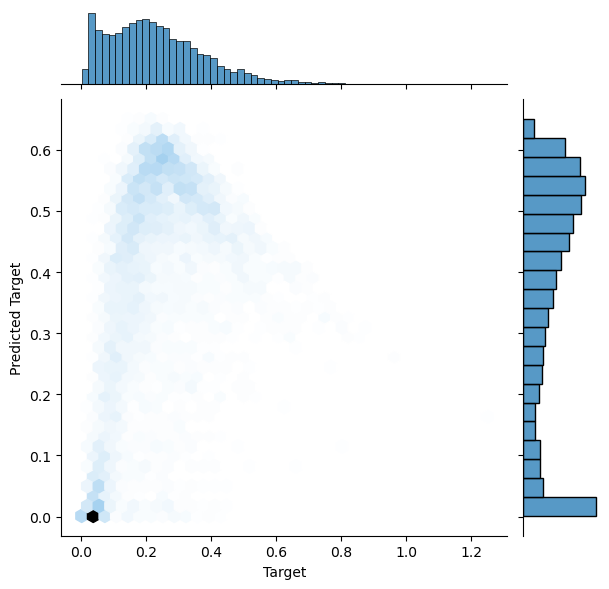

In [28]:
import seaborn as sns
sns.jointplot(x = test_data[output_cols[0]], y = mu[:, 0], kind = 'hex')
plt.xlabel('Target')
plt.ylabel('Predicted Target')
plt.show()

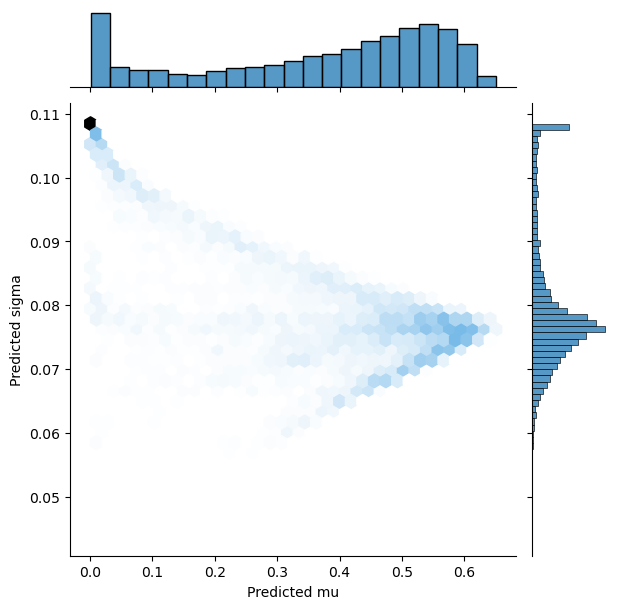

In [29]:
sns.jointplot(x = mu[:, 0], y = np.sqrt(var)[:, 0], kind = 'hex')
plt.xlabel('Predicted mu')
plt.ylabel('Predicted sigma')
plt.show()

### 3. Compute mu, aleatoric, and epistemic quantities using the evidential model

In [30]:
from mlguess.keras.models import EvidentialRegressorDNN

In [31]:
config = "../config/surface_layer/evidential.yml"

In [32]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)
    
conf["model"]["epochs"] = 5
conf["model"]["verbose"] = 1

In [33]:
ev_model = EvidentialRegressorDNN(**conf["model"])
ev_model.build_neural_network(x_train.shape[-1], y_train.shape[-1])

In [34]:
ev_model.fit(
    x_train,
    y_train,
    validation_data=(x_valid, y_valid),
    callbacks=get_callbacks(conf, path_extend=f""),
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 dense_00 (Dense)            (None, 295)               1475      
                                                                 
 dropout_h_00 (Dropout)      (None, 295)               0         
                                                                 
 DenseNormalGamma (DenseNor  (None, 4)                 1188      
 malGamma)                                                       
                                                                 
Total params: 2663 (10.40 KB)
Trainable params: 2659 (10.39 KB)
Non-trainable params: 4 (16.00 Byte)
_________________________________________________________________
Epoch 1/5
12/12 [==============================] - 2s 50ms/step - loss: 7.1618 - mae: 0.08

/glade/work/ggantos/conda-envs/guess/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 1s 44ms/step - loss: 2.9766 - mae: 0.0311 - val_loss: 2.3195 - val_mae: 0.0246 - lr: 0.0056
Epoch 3/5
 1/12 [=>............................] - ETA: 0s - loss: 2.3755 - mae: 0.0243

/glade/work/ggantos/conda-envs/guess/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 37ms/step - loss: 2.4158 - mae: 0.0257 - val_loss: 2.4984 - val_mae: 0.0294 - lr: 0.0056
Epoch 4/5
12/12 [==============================] - 1s 47ms/step - loss: 2.2148 - mae: 0.0246 - val_loss: 2.0650 - val_mae: 0.0247 - lr: 0.0056
Epoch 5/5
11/12 [==========================>...] - ETA: 0s - loss: 2.0106 - mae: 0.0227

/glade/work/ggantos/conda-envs/guess/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 37ms/step - loss: 2.0098 - mae: 0.0227 - val_loss: 2.0103 - val_mae: 0.0231 - lr: 5.6263e-04


In [35]:
result = ev_model.predict_uncertainty(x_test, scaler=y_scaler)
mu, aleatoric, epistemic = result

2/2 [==============================] - 0s 7ms/step


In [36]:
mae = np.mean(np.abs(mu[:, 0]-test_data[output_cols[0]]))
print(mae, np.mean(aleatoric) ** (1/2), np.mean(epistemic) ** (1/2))

0.031027311374899676 0.06562523302536419 0.09634488830054809


In [37]:
from mlguess.regression_uq import compute_results

/glade/work/ggantos/miles-guess/mlguess/regression_uq.py:737: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_name, bin_group in df.groupby('bin'):
/glade/work/ggantos/miles-guess/mlguess/regression_uq.py:757: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = result_df._append({'bin': bin_left, 'rmse': rmse, 'crps': crps, 'count': count}, ignore_index=True)
/glade/work/ggantos/miles-guess/mlguess/regression_uq.py:819: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tig

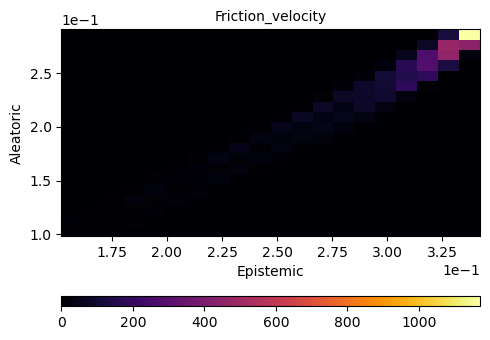

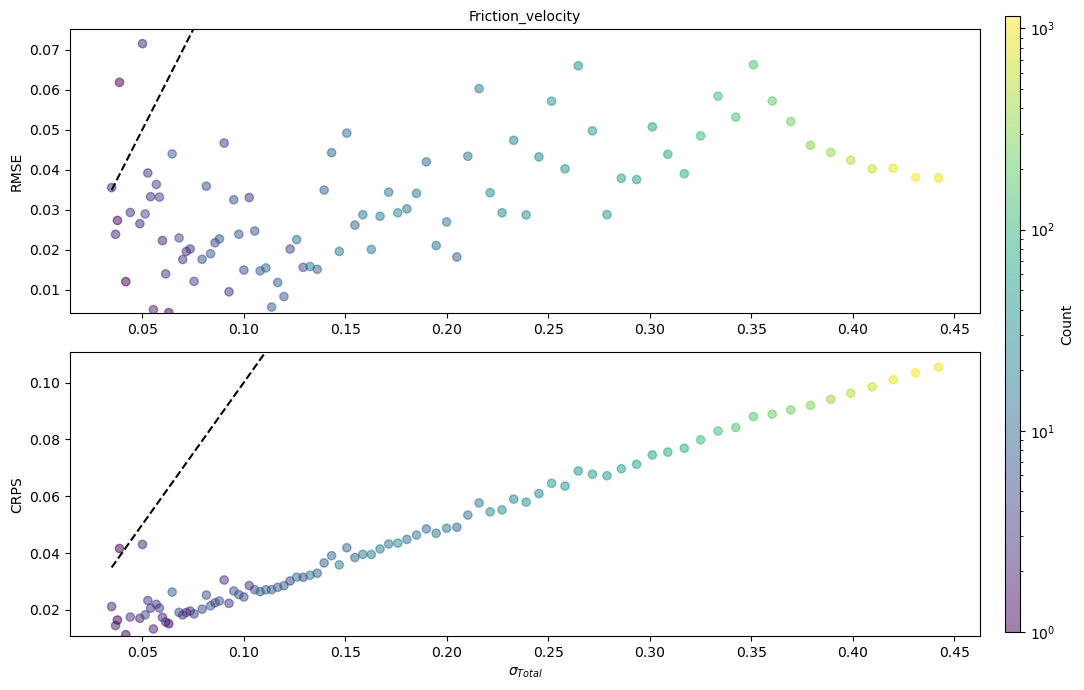

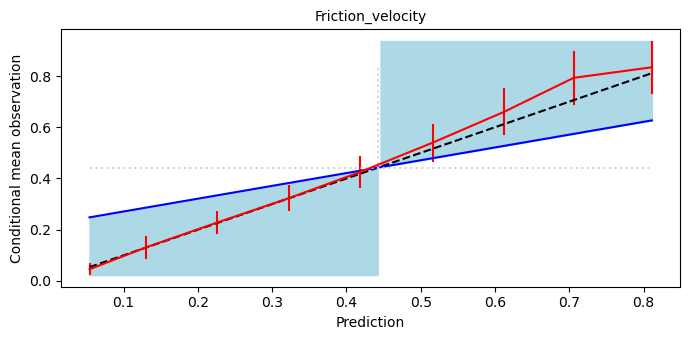

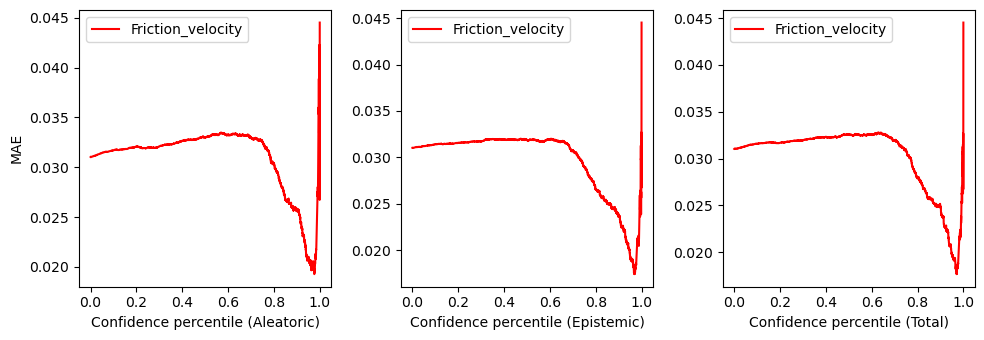

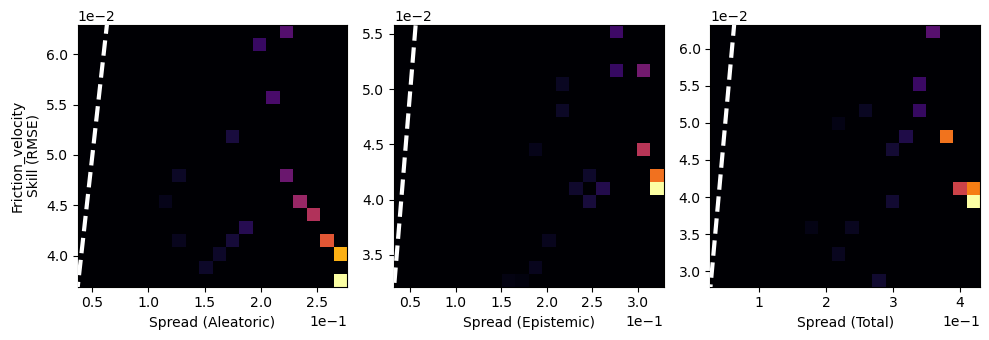

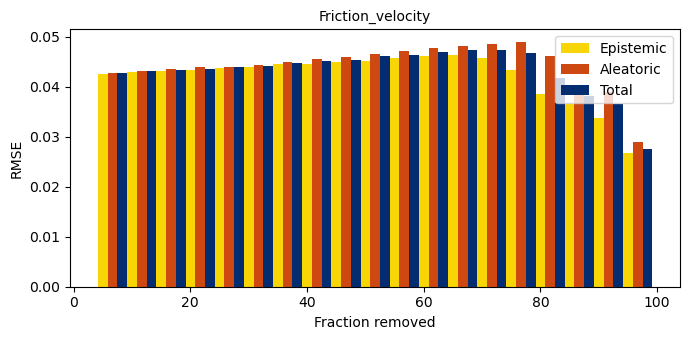

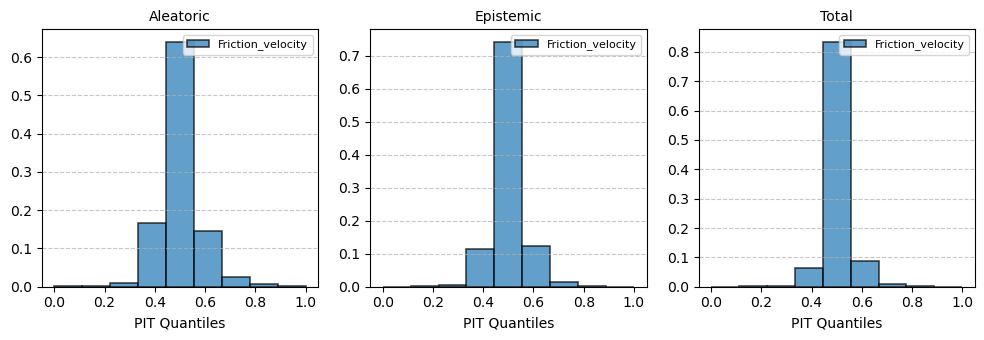

In [38]:
compute_results(test_data, output_cols, mu, np.sqrt(aleatoric), np.sqrt(epistemic))

### 4. Create a deep ensemble with the Gaussian model so that the law of total variance can be applied to compute aleatoric and epistemic

In [39]:
config = "../config/surface_layer/gaussian.yml"
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)
    
conf["save_loc"] = "./"
conf["model"]["epochs"] = 1
conf["model"]["verbose"] = 0
n_splits = conf["ensemble"]["n_splits"]

In [40]:
# make save directory for model weights
os.makedirs(os.path.join(conf["save_loc"], "cv_ensemble", "models"), exist_ok=True)

In [41]:
data_seed = 0
gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
splits = list(gsp.split(data, groups = data["day"]))
train_index, test_index = splits[0]

In [42]:
ensemble_mu = np.zeros((n_splits, test_data.shape[0], 1))
ensemble_var = np.zeros((n_splits, test_data.shape[0], 1))

for data_seed in tqdm.tqdm(range(n_splits)):
    data = pd.read_csv(fn)
    data["day"] = data["Time"].apply(lambda x: str(x).split(" ")[0])

    # Need the same test_data for all trained models (data and model ensembles)
    flat_seed = 1000
    gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
    splits = list(gsp.split(data, groups = data["day"]))
    train_index, test_index = splits[0]
    train_data, test_data = data.iloc[train_index].copy(), data.iloc[test_index].copy() 

    # Make N train-valid splits using day as grouping variable
    gsp = GroupShuffleSplit(n_splits=n_splits,  random_state = flat_seed, train_size=0.885)
    splits = list(gsp.split(train_data, groups = train_data["day"]))
    train_index, valid_index = splits[data_seed]
    train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy()  

    x_scaler, y_scaler = RobustScaler(), MinMaxScaler((0, 1))
    x_train = x_scaler.fit_transform(train_data[input_cols])
    x_valid = x_scaler.transform(valid_data[input_cols])
    x_test = x_scaler.transform(test_data[input_cols])

    y_train = y_scaler.fit_transform(train_data[output_cols])
    y_valid = y_scaler.transform(valid_data[output_cols])
    y_test = y_scaler.transform(test_data[output_cols])
    
    model = GaussianRegressorDNN(**conf["model"])
    model.build_neural_network(x_train.shape[-1], y_train.shape[-1])
    
    model.fit(
        x_train,
        y_train,
        validation_data=(x_valid, y_valid),
        callbacks=get_callbacks(conf, path_extend=f"")
    )
    
    model.model_name = f"cv_ensemble/models/model_seed0_split{data_seed}.h5"
    model.save_model()
    
    # Save the best model 
    model.model_name = f"cv_ensemble/models/best.h5"
    model.save_model()
    
    mu, var = model.predict_uncertainty(x_test, y_scaler)
    mae = np.mean(np.abs(mu[:, 0]-test_data[output_cols[0]]))
    
    ensemble_mu[data_seed] = mu
    ensemble_var[data_seed] = var

  0%|          | 0/2 [00:00<?, ?it/s]/glade/work/ggantos/conda-envs/guess/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 6ms/step


/glade/work/ggantos/miles-guess/mlguess/keras/models.py:250: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(
 50%|█████     | 1/2 [00:02<00:02,  2.90s/it]/glade/work/ggantos/conda-envs/guess/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/glade/work/ggantos/miles-guess/mlguess/keras/models.py:250: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(


3/3 [==============================] - 0s 6ms/step


100%|██████████| 2/2 [00:05<00:00,  2.95s/it]


##### Use the method predict_ensemble to accomplish the same thing given pretrained models:

In [43]:
model = GaussianRegressorDNN().load_model(conf)

In [44]:
#models = [f"./model_split{data_seed}.h5" for data_seed in range(n_splits)]
ensemble_mu, ensemble_var = model.predict_ensemble(x_test, scaler = y_scaler)

3/3 [==============================] - 0s 8ms/step


In [45]:
epistemic = np.var(ensemble_mu, axis=0)
aleatoric = np.mean(ensemble_var, axis=0)

In [46]:
print(epistemic.mean() ** (1/2), aleatoric.mean() ** (1/2))

0.01429017466226209 0.08474143027180914


/glade/work/ggantos/miles-guess/mlguess/regression_uq.py:737: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_name, bin_group in df.groupby('bin'):
/glade/work/ggantos/miles-guess/mlguess/regression_uq.py:757: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = result_df._append({'bin': bin_left, 'rmse': rmse, 'crps': crps, 'count': count}, ignore_index=True)
/glade/work/ggantos/miles-guess/mlguess/regression_uq.py:819: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tig

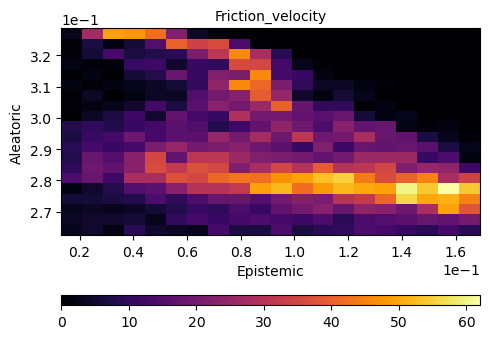

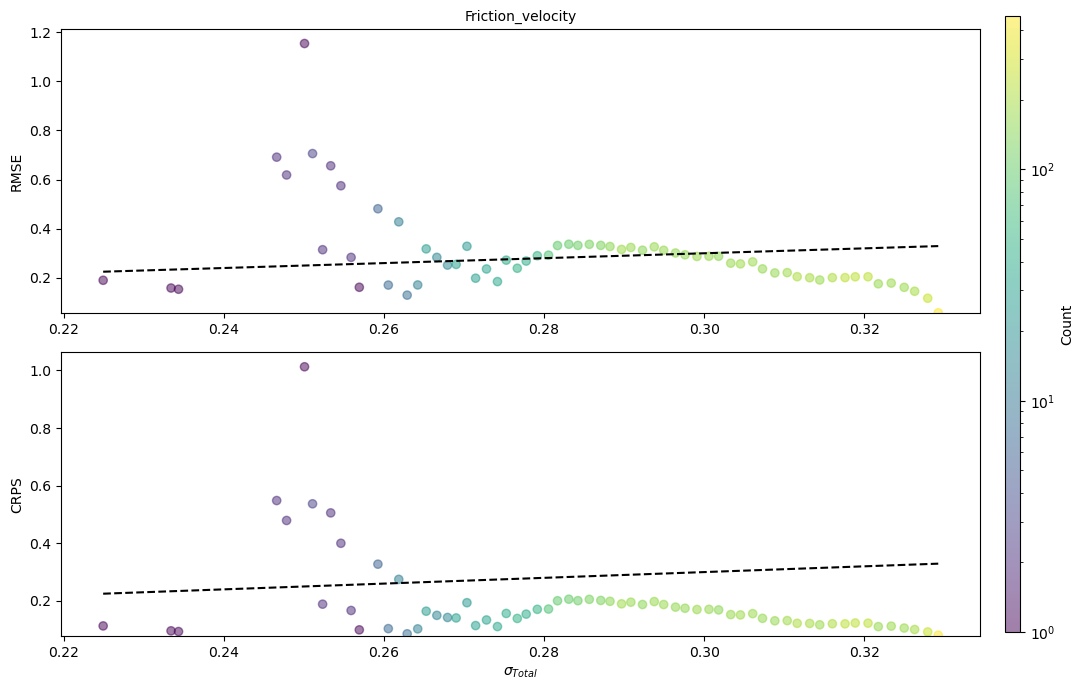

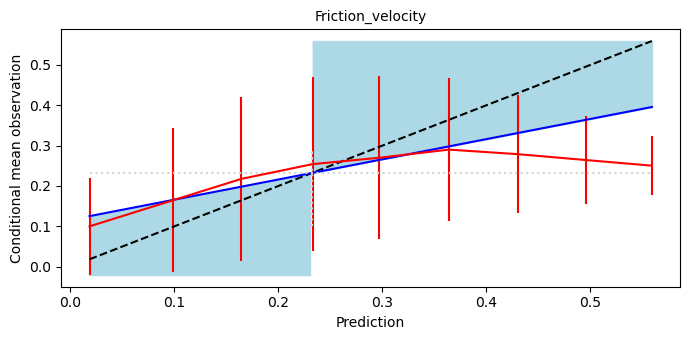

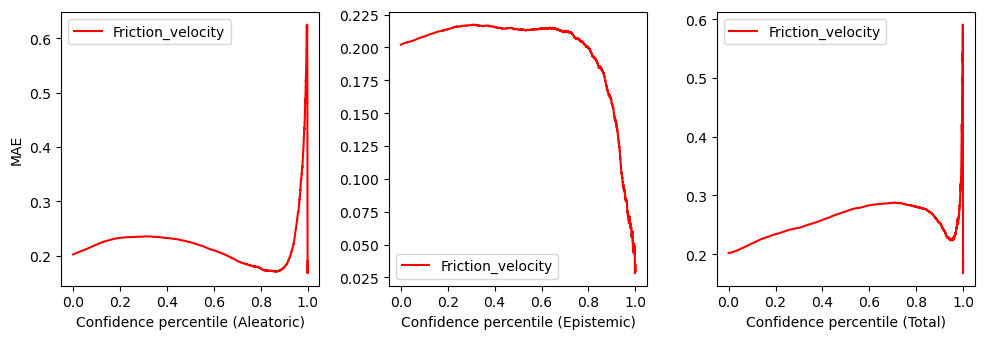

/glade/work/ggantos/conda-envs/guess/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2069: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/glade/work/ggantos/conda-envs/guess/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2069: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/glade/work/ggantos/conda-envs/guess/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2069: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


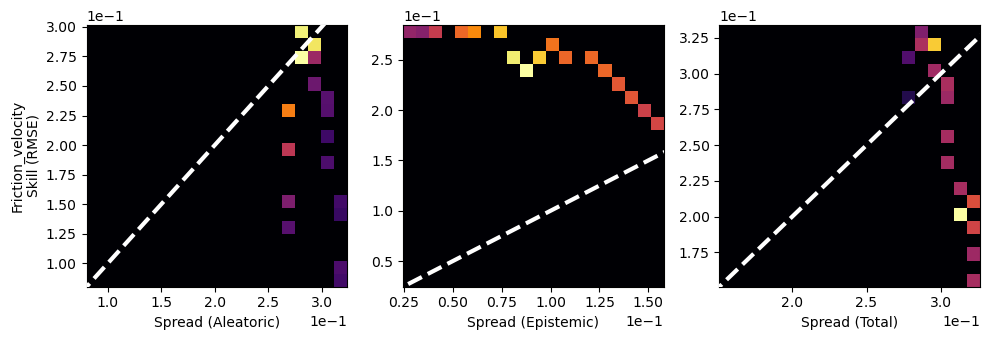

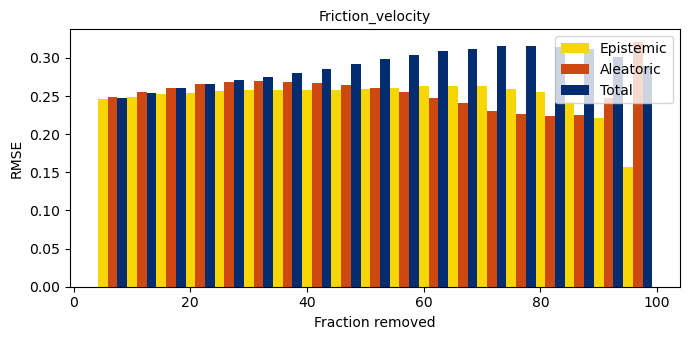

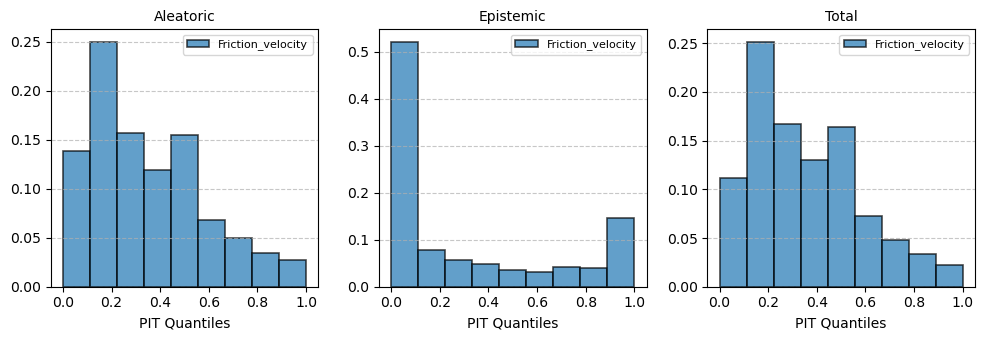

In [47]:
compute_results(test_data, output_cols, np.mean(ensemble_mu, axis=0), np.sqrt(aleatoric), np.sqrt(epistemic))

### 5. Use Monte Carlo dropout with the Gaussian model to compute aleatoric and epistemic uncertainties

In [49]:
monte_carlo_steps = 10

ensemble_mu, ensemble_var = model.predict_monte_carlo(x_test, monte_carlo_steps, scaler = y_scaler)

In [50]:
ensemble_epistemic = np.var(ensemble_mu, axis=0)
ensemble_aleatoric = np.mean(ensemble_var, axis=0)
ensemble_mean = np.mean(ensemble_mu, axis=0)